In [ ]:
from fastai import *
from fastai.vision import *

import warnings
warnings.filterwarnings('ignore', message='Default grid_sample and affine_grid behavior will be changed ')

In [ ]:
path = Path('/home/kushaj/Desktop/Data/')
train_path = path/'trashdata/'
test_path = path/'trashtest'

print(train_path.ls())
print(test_path.ls())

[PosixPath('/home/kushaj/Desktop/Data/trashdata/metal'), PosixPath('/home/kushaj/Desktop/Data/trashdata/glass'), PosixPath('/home/kushaj/Desktop/Data/trashdata/paper'), PosixPath('/home/kushaj/Desktop/Data/trashdata/.DS_Store'), PosixPath('/home/kushaj/Desktop/Data/trashdata/cardboard'), PosixPath('/home/kushaj/Desktop/Data/trashdata/models'), PosixPath('/home/kushaj/Desktop/Data/trashdata/plastic')]
[PosixPath('/home/kushaj/Desktop/Data/trashtest/metal'), PosixPath('/home/kushaj/Desktop/Data/trashtest/glass'), PosixPath('/home/kushaj/Desktop/Data/trashtest/paper'), PosixPath('/home/kushaj/Desktop/Data/trashtest/cardboard'), PosixPath('/home/kushaj/Desktop/Data/trashtest/plastic')]


In [ ]:
src = (ImageList.from_folder(train_path)
                .split_by_rand_pct()
                .label_from_folder())

data = (src.transform(get_transforms(flip_vert=True), size=(128, 128))
           .databunch(bs=32, val_bs=64, num_workers=8)
           .normalize(imagenet_stats))

data_test = (ImageList.from_folder(test_path)
                      .split_none()
                      .label_from_folder()
                      .transform(size=(256, 256))
                      .databunch(num_workers=8, val_bs=32)
                      .normalize(imagenet_stats))

data_test.valid_dl = data_test.train_dl
data_test.train_dl = None

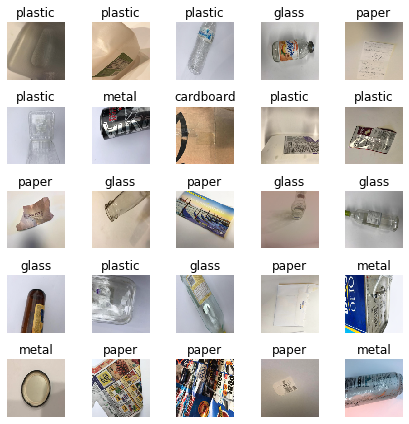

In [ ]:
data.show_batch(figsize=(6,6))

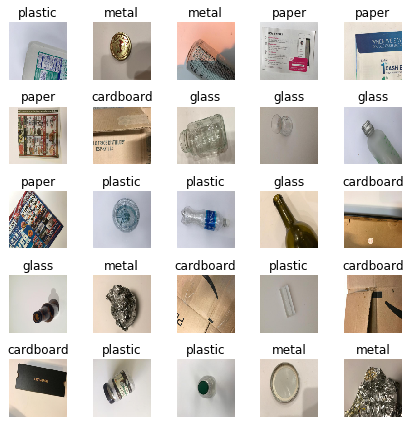

In [ ]:
data_test.show_batch(figsize=(6,6))

In [ ]:
import torchvision
model = torchvision.models.mobilenet_v2(pretrained=True)
model = nn.Sequential(*list(model.children()))
f_score = partial(fbeta, beta=1)

model[1] = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(),
    nn.BatchNorm1d(2560),
    nn.Dropout(0.5),
    nn.Linear(2560, 5, bias=True)
)

def freeze(model):
    for param in model[0].parameters():
        param.requires_grad = False

def unfreeze(model):
    for param in model[0].parameters():
        param.requires_grad = True

def print_params(model):
    for param in model.parameters():
        print(param.requires_grad)

In [ ]:
learn = Learner(data, model, metrics=[accuracy], callback_fns=ShowGraph)

In [ ]:
freeze(learn.model)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


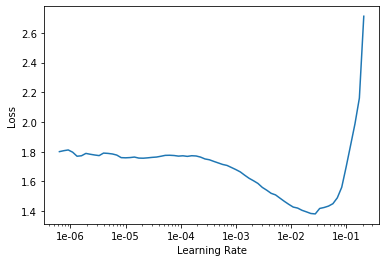

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.802967,1.587965,0.296729,00:08
1,1.607061,1.248579,0.544393,00:08
2,1.339600,0.984920,0.644860,00:07
3,1.094824,0.831148,0.696262,00:08
4,0.948698,0.762639,0.714953,00:08
5,0.861830,0.731968,0.731308,00:08
6,0.759717,0.710096,0.745327,00:08
7,0.750105,0.700486,0.735981,00:08
8,0.727389,0.697149,0.747664,00:08
9,0.733819,0.686481,0.752336,00:08


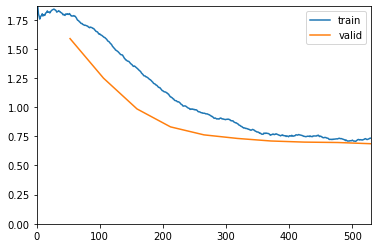

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-4)

In [ ]:
unfreeze(learn.model)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


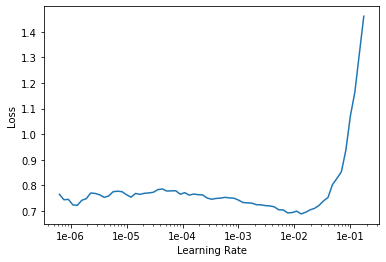

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.724308,0.694539,0.745327,00:13
1,0.725272,0.673508,0.752336,00:13
2,0.712949,0.672843,0.757009,00:13
3,0.689020,0.649475,0.757009,00:12
4,0.672785,0.624937,0.764019,00:13
5,0.659803,0.608506,0.761682,00:13
6,0.617375,0.588771,0.773364,00:13
7,0.623292,0.578542,0.775701,00:13
8,0.618614,0.570994,0.764019,00:13
9,0.593659,0.572089,0.768692,00:13


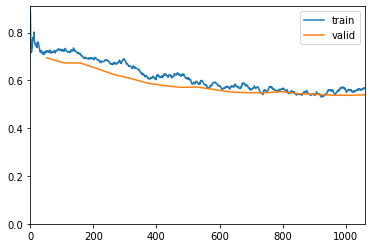

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-4)

In [ ]:
learn.save('stage_1')

In [ ]:
data = (src.transform(get_transforms(flip_vert=True), size=(256, 256))
           .databunch(bs=16, val_bs=32, num_workers=8)
           .normalize(imagenet_stats))

In [ ]:
learn.data = data

In [ ]:
freeze(learn.model)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


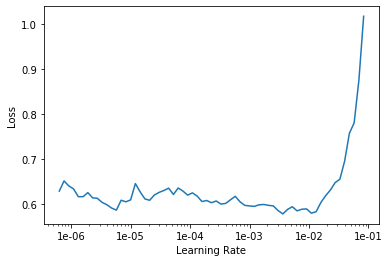

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.541188,0.443503,0.843458,00:15
1,0.504526,0.420343,0.838785,00:15
2,0.557232,0.382327,0.869159,00:15
3,0.529674,0.390527,0.848131,00:15
4,0.501583,0.398830,0.841121,00:15
5,0.508381,0.383171,0.869159,00:15
6,0.458582,0.361091,0.866822,00:15
7,0.407232,0.366447,0.869159,00:15
8,0.445509,0.369716,0.871495,00:15
9,0.405648,0.378049,0.852804,00:15


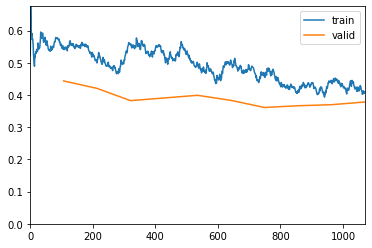

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-3)

In [ ]:
learn.save('stage2_a')

In [ ]:
unfreeze(learn.model)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


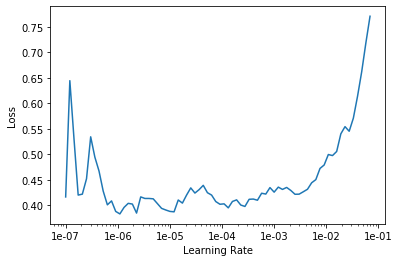

In [ ]:
learn.recorder.plot(skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,0.415647,0.370140,0.869159,00:40
1,0.429288,0.375315,0.859813,00:40
2,0.397526,0.388393,0.850467,00:40
3,0.407695,0.369987,0.862150,00:40
4,0.419884,0.368881,0.869159,00:40


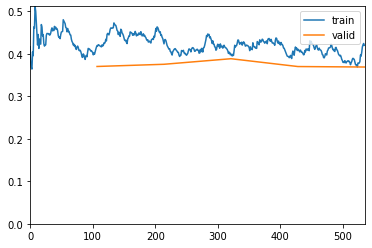

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.save('stage2_b')

In [ ]:
learn.validate(dl=data_test.valid_dl)

[0.23179753, tensor(0.9115)]